In [1]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf
from sklearn.preprocessing import MinMaxScaler
import os

In [22]:
# Dataset
df=pd.read_csv('./../../dataset/raw_jawa_barat.csv', parse_dates=["date"], index_col="date")
#df['daily_case'] = df['daily_case'].str.replace(',','').astype(int)

# Cut dataset to start from 1 April 2022
df = df[243:]
df.head()

,daily_case
date,
2020-11-01,239
2020-11-02,325
2020-11-03,517
2020-11-04,571
2020-11-05,667


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 2020-11-01 to 2022-05-06
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   daily_case  552 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [24]:
df.shape

(552, 1)

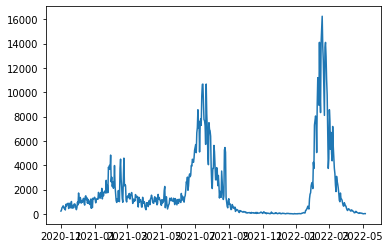

In [25]:
plt.plot(df)

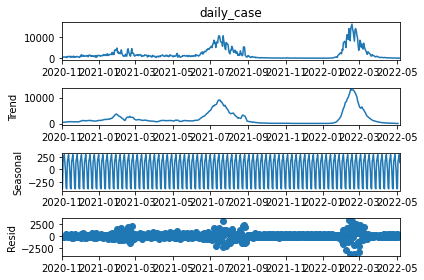

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['daily_case'])
results.plot();

In [27]:
df.shape

(552, 1)

In [28]:
# Split data to train and test
train_size = int(len(df) - 30)
test_size=len(df)-train_size

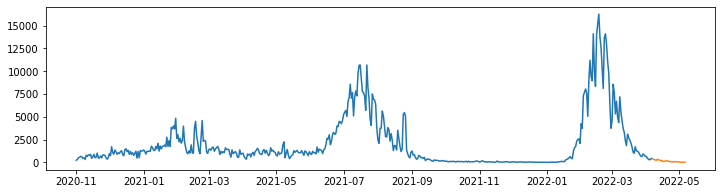

In [29]:
train_data=df[:train_size]
test_data=df[train_size:]
plt.figure(figsize=(12, 3))
plt.plot(train_data)
plt.plot(test_data)

In [30]:
from statsmodels.tsa.stattools import adfuller
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [31]:
adfuller_test(df['daily_case'])

ADF Test Statistic : -3.611526843020844
p-value : 0.005544444722590224
#Lags Used : 17
Number of Observations Used : 534
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [32]:
from pmdarima.arima import auto_arima
stepwise_fit = auto_arima(df['daily_case'], trace=True, seasonal=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=9070.244, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10314.499, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9097.572, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9778.525, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10533.809, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=9067.327, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=9542.167, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9093.466, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9070.641, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=9422.540, Time=0.50 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9099.871, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=9071.152, Time=0.37 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=9067.258, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=9676.314, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]        

In [33]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  552
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -4529.629
Date:                Thu, 12 May 2022   AIC                           9067.258
Time:                        01:55:43   BIC                           9084.512
Sample:                             0   HQIC                          9073.999
                                - 552                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.003    299.943      0.000       0.979       0.992
ma.L1         -0.1695      0.022     -7.665      0.000      -0.213      -0.126
ma.L2         -0.2368      0.025     -9.586      0.000      -0.285      -0.188
sigma2      7.894e+05    2.1e+04     37.605      0.000    7.48e+05    8.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2451.59
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.87   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
print(train_data.shape,test_data.shape)

(522, 1) (30, 1)


In [49]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train_data['daily_case'],order=(4,1,5))
model=model.fit()
model.summary()

C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\envs\colab_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             daily_case   No. Observations:                  522
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -4247.610
Date:                Thu, 12 May 2022   AIC                           8515.219
Time:                        01:59:03   BIC                           8557.777
Sample:                    11-01-2020   HQIC                          8531.889
                         - 04-06-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8063      0.050     16.271      0.000       0.709       0.903
ar.L2         -1.4074      0.042    -33.171      0.000      -1.491      -1.324
ar.L3          0.7364      0.049     15.028      0.000       0.640       0.832
ar.L4         -0.8605      0.033    -26.299      0.000      -0.925      -0.796
ma.L1         -1.0422      0.064    -16.330      0.000      -1.167      -0.917
ma.L2          1.4507      0.080     18.083      0.000       1.294       1.608
ma.L3         -0.9689      0.085    -11.364      0.000      -1.136      -0.802
ma.L4          0.7848      0.066     11.831      0.000       0.655       0.915
ma.L5         -0.1506      0.041     -3.643      0.000      -0.232      -0.070
sigma2      7.824e+05   2.52e+04     31.089      0.000    7.33e+05    8.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1587.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

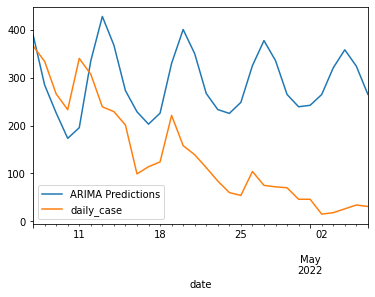

In [50]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test_data['daily_case'].plot(legend=True)

In [37]:
model = auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=30,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[30] intercept   : AIC=8598.146, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=8627.450, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8622.881, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8617.512, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=8625.451, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=8599.084, Time=0.06 sec
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=8600.143, Time=2.04 sec
 ARIMA(1,1,1)(0,0,2)[30] intercept   : AIC=8600.143, Time=3.24 sec
 ARIMA(1,1,1)(1,0,0)[30] intercept   : AIC=8598.174, Time=0.53 sec
 ARIMA(1,1,1)(1,0,2)[30] intercept   : AIC=8602.144, Time=3.69 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=8622.887, Time=0.26 sec
 ARIMA(2,1,1)(0,0,1)[30] intercept   : AIC=8590.763, Time=1.56 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8590.233, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[30] intercept   : AIC=8590.771, Time=1.58 sec
 ARIMA(2,1,1)(1,0,1

KeyboardInterrupt: 

In [ ]:
# model=auto_arima(train_data,start_p=0,d=1,start_q=0,
#           max_p=5,max_d=5,max_q=5, start_P=0,
#           D=1, start_Q=0, max_P=5,max_D=5,
#           max_Q=5, m=12, seasonal=True,
#           error_action='warn',trace=True,
#           supress_warnings=True,stepwise=True,
#           random_state=20,n_fits=50)

In [ ]:
prediction = pd.DataFrame(model.predict(n_periods = 77), index=test_data.index)
prediction.columns = ['predicted_case']
prediction

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_data, label="Training")
plt.plot(test_data, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
prediction_series = pd.Series(prediction,index=test_data.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.Value)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [ ]:
print(len(train_data)), print(len(test_data))

In [ ]:
# Create dataset matrix based on timestep
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Reshape into x=t, t+1, t+2, ... t+n, and Y = t + (n+1)
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape), print(Y_train.shape)

In [ ]:
print(X_test.shape), print(Y_test.shape)

In [ ]:
len(X_test)